In [26]:

import tensorflow as tf
import numpy as np
import random
import os

In [27]:
# Set a fixed seed value for reproducibility
SEED = 1
random.seed(SEED)            # Python random module
np.random.seed(SEED)         # NumPy
tf.random.set_seed(SEED)     # TensorFlow


In [28]:
# Enforce deterministic behavior for GPU operations
os.environ['TF_DETERMINISTIC_OPS'] = '1'  # Ensure deterministic execution
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'  # Deterministic cuDNN algorithms


In [29]:
# Control GPU memory allocation (prevents TensorFlow from using all GPU memory)
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)  # Enable memory growth

# Restrict parallelism (ensures consistent execution order)
tf.config.threading.set_inter_op_parallelism_threads(1)
tf.config.threading.set_intra_op_parallelism_threads(1)

In [30]:
# import os
import scipy.io #to load matlab files 
# import numpy as np
from sklearn.model_selection import train_test_split #for data splitting #, KFold
from sklearn.metrics import confusion_matrix
# import tensorflow as tf
from tensorflow.keras import layers, models #build and train CNN model
import matplotlib.pyplot as plt #for plotting confusion matrices and accuracy metrics
import seaborn as sns 
# import pandas as pd

from scipy import signal #for computing spectograms
from skimage.transform import resize #for resizing data
from sklearn.model_selection import StratifiedKFold

In [31]:
"""
# -----------------------------------------------------------------------------
# Read CWRU Bearing Data (Load - 2HP)
# -----------------------------------------------------------------------------
"""
def ImportData():
  folder_path = 'CWRU_BearingData_Load_2HP' 
  # X99_normal = scipy.io.loadmat('content/drive/MyDrive/BearingData_CaseWestern/99.mat')['X099_DE_time'] 
  file_path1 = os.path.join(folder_path, '99.mat')
  X99_normal = scipy.io.loadmat(file_path1)['X099_DE_time'] #vibration data extracted from X099_DE_time key (drive-end accelerometer data)

    
  # X111_InnerRace_007 = scipy.io.loadmat('/content/drive/MyDrive/BearingData_CaseWestern/111.mat')['X111_DE_time']
  file_path2 = os.path.join(folder_path, '111.mat')
  X111_InnerRace_007  = scipy.io.loadmat(file_path2)['X111_DE_time']

  # X124_Ball_007 = scipy.io.loadmat('/content/drive/MyDrive/BearingData_CaseWestern/124.mat')['X124_DE_time']
  file_path3 = os.path.join(folder_path, '124.mat')
  X124_Ball_007 = scipy.io.loadmat(file_path3)['X124_DE_time']

  # X137_Outer_007 = scipy.io.loadmat('/content/drive/MyDrive/BearingData_CaseWestern/137.mat')['X137_DE_time']
  file_path4 = os.path.join(folder_path, '137.mat')
  X137_Outer_007 = scipy.io.loadmat(file_path4)['X137_DE_time']
    
  # X176_InnerRace_014 = scipy.io.loadmat('/content/drive/MyDrive/BearingData_CaseWestern/176.mat')['X176_DE_time']
  file_path5 = os.path.join(folder_path, '176.mat')
  X176_InnerRace_014 = scipy.io.loadmat(file_path5)['X176_DE_time']

  # X191_Ball_014 = scipy.io.loadmat('/content/drive/MyDrive/BearingData_CaseWestern/191.mat')['X191_DE_time']
  file_path6 = os.path.join(folder_path, '191.mat')
  X191_Ball_014 = scipy.io.loadmat(file_path6)['X191_DE_time']
    
  # X203_Outer_014 = scipy.io.loadmat('/content/drive/MyDrive/BearingData_CaseWestern/203.mat')['X203_DE_time']
  file_path7 = os.path.join(folder_path, '203.mat')
  X203_Outer_014  = scipy.io.loadmat(file_path7)['X203_DE_time']

  #  X215_InnerRace_021 = scipy.io.loadmat('/content/drive/MyDrive/BearingData_CaseWestern/215.mat')['X215_DE_time']
  file_path8 = os.path.join(folder_path, '215.mat')
  X215_InnerRace_021  = scipy.io.loadmat(file_path8)['X215_DE_time']
    
  # X228_Ball_021 = scipy.io.loadmat('/content/drive/MyDrive/BearingData_CaseWestern/228.mat')['X228_DE_time']
  file_path9 = os.path.join(folder_path, '228.mat')
  X228_Ball_021  = scipy.io.loadmat(file_path9)['X228_DE_time']

  # X240_Outer_021 = scipy.io.loadmat('/content/drive/MyDrive/BearingData_CaseWestern/240.mat')['X240_DE_time']
  file_path10 = os.path.join(folder_path, '240.mat')
  X240_Outer_021  = scipy.io.loadmat(file_path10)['X240_DE_time'] 
  
    
  return [X99_normal,X111_InnerRace_007,X124_Ball_007,X137_Outer_007,X176_InnerRace_014,X191_Ball_014,X203_Outer_014,X215_InnerRace_021,X228_Ball_021,X240_Outer_021]

In [32]:
"""
# -----------------------------------------------------------------------------
# Data Processing and Feature Extraction
# -----------------------------------------------------------------------------
"""
# def Sampling(Data, interval_length, samples_per_block):
#     No_of_blocks = (round(len(Data)/interval_length) - round(samples_per_block/interval_length) - 1)
#     SplitData = np.zeros([No_of_blocks, samples_per_block])
#     for i in range(No_of_blocks):
#         SplitData[i,:] = Data[i*interval_length:(i*interval_length)+samples_per_block].T
#     return SplitData

#segments the time-series data into smaller blocks for processing
#data: 1D numpy array of vibration data
#interval length: step size (in samples) betweeen the start of consectuive blocks
#samples_per_block: no. of samples in each block (fixed at 1600 in the code)
#ignore_points: no. of points to skip at start and end of data(default is 0)
def Sampling(Data, interval_length, samples_per_block, ignore_points=0):
    # Adjust data length to ignore the first and last 'ignore_points'
    adjusted_length = len(Data) - 2 * ignore_points
    # Adjust the number of blocks
    No_of_blocks = (round(adjusted_length / interval_length) - round(samples_per_block / interval_length) - 1)
    SplitData = np.zeros([No_of_blocks, samples_per_block]) #splitdata matrix where each row is a block of samples_per_block samples
    
    for i in range(No_of_blocks):
        # Skip the first 'ignore_points' and start sampling from that position
        start_idx = ignore_points + i * interval_length
        SplitData[i, :] = Data[start_idx:(start_idx + samples_per_block)].T #.T transpose ensure the data is correctly oriented (since the input is a column vector)
    
    return SplitData #2D array of shape - no.ofblocks, samples_per_block)


def DataPreparation(Data, interval_length, samples_per_block):
  for count,i in enumerate(Data):
    SplitData = Sampling(i, interval_length, samples_per_block) #for each dataset calls samplying to create blocks of 1600 samples
    y = np.zeros([len(SplitData),10]) #y (one-hot encoded): Shape (No_of_blocks, 10), where the column corresponding to the class is set to 1 (e.g., for class 0, [1, 0, 0, ..., 0])
    y[:,count] = 1
    y1 = np.zeros([len(SplitData),1]) #y1 (integer labels): Shape (No_of_blocks, 1), where each element is the class index (0 to 9).
    y1[:,0] = count 
    # Stack up and label the data   
    if count==0:
      X = SplitData
      LabelPositional = y
      Label = y1
    else:
      X = np.append(X, SplitData, axis=0)
      LabelPositional = np.append(LabelPositional,y,axis=0)
      Label = np.append(Label,y1,axis=0)
  print(X)
  return X, LabelPositional, Label

In [108]:
Data = ImportData()
for i, d in enumerate(Data):
    print(f"Dataset {i+1} shape: {d.shape}")
    
interval_length = 1600 #320 #290 #200  
samples_per_block = 1296 #1600 #1650-25*2


# Y_CNN is of shape (n, 10) representing 10 classes as 10 columns. In each sample, for the class to which it belongs, 
# the corresponding column value is marked 1 and the rest as 0, facilitating Softmax implementation in CNN 
# Y is of shape (m, 1) where column values are between 0 and 9 representing the classes directly. - 1-hot encoding
X, Y_CNN, Y = DataPreparation(Data, interval_length, samples_per_block) 


print('Shape of Input Data =', X.shape)
print('Shape of Label Y_CNN =', Y_CNN.shape)
print('Shape of Label Y =', Y.shape)

# XX = {'X':X}
# scipy.io.savemat('Data.mat', XX)


Dataset 1 shape: (485063, 1)
Dataset 2 shape: (485643, 1)
Dataset 3 shape: (486804, 1)
Dataset 4 shape: (486804, 1)
Dataset 5 shape: (487964, 1)
Dataset 6 shape: (487384, 1)
Dataset 7 shape: (486804, 1)
Dataset 8 shape: (491446, 1)
Dataset 9 shape: (487384, 1)
Dataset 10 shape: (487964, 1)
[[ 0.06425354  0.06300185 -0.00438092 ... -0.029832   -0.018984
  -0.002712  ]
 [ 0.08615815  0.06446215  0.06154154 ... -0.07238954 -0.024408
  -0.02086154]
 [-0.02712    -0.00104308  0.03004062 ... -0.02002708 -0.03379569
  -0.06049846]
 ...
 [-0.202824   -0.13438133 -0.06176533 ... -0.097656   -0.15190933
  -0.16109067]
 [ 0.197816    0.34889067  0.39396267 ... -1.02079733 -0.981568
  -0.78709067]
 [ 0.16276     0.020032   -0.08764    ...  0.097656    0.10349867
   0.09682133]]
Shape of Input Data = (3026, 1296)
Shape of Label Y_CNN = (3026, 10)
Shape of Label Y = (3026, 1)


In [ ]:
def min_max_norm(ary):
    ary = (ary - ary.min()) / np.abs(ary.max() - ary.min())
    return ary

def generate_spectrogram_image(data_y_vector, image_shape):
    """
    Calculate the spectrogram of an array data_y_vector and resize it in 
    the image_shape resolution
    """
    fs = 48000
    # data_y_vector_len = np.shape(data_y_vector)[0]

    f, t, sxx = signal.spectrogram(
        data_y_vector,
        fs)

    sxx = min_max_norm(sxx)
    sxx = resize(sxx, image_shape, mode='constant', anti_aliasing=True)

    return sxx


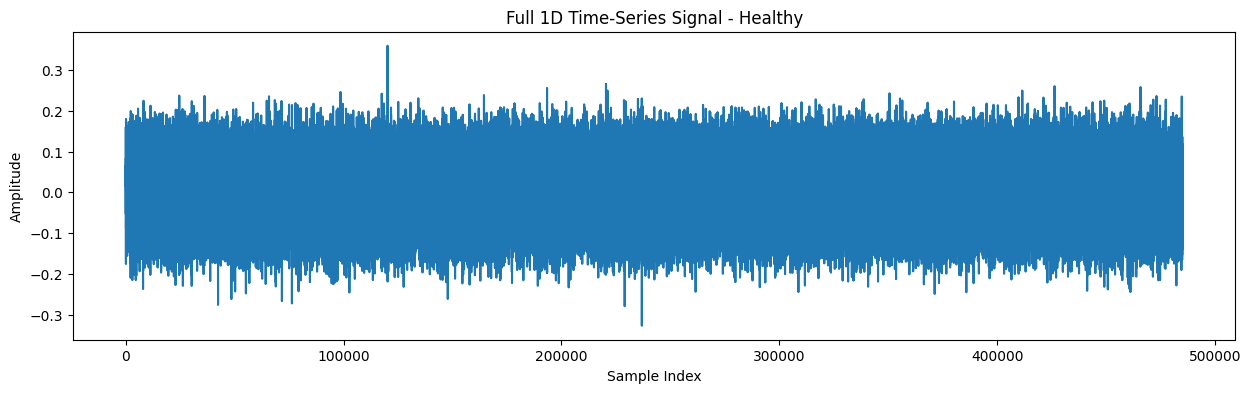

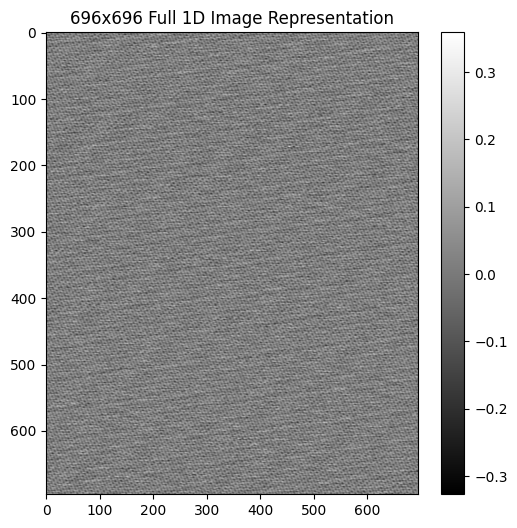

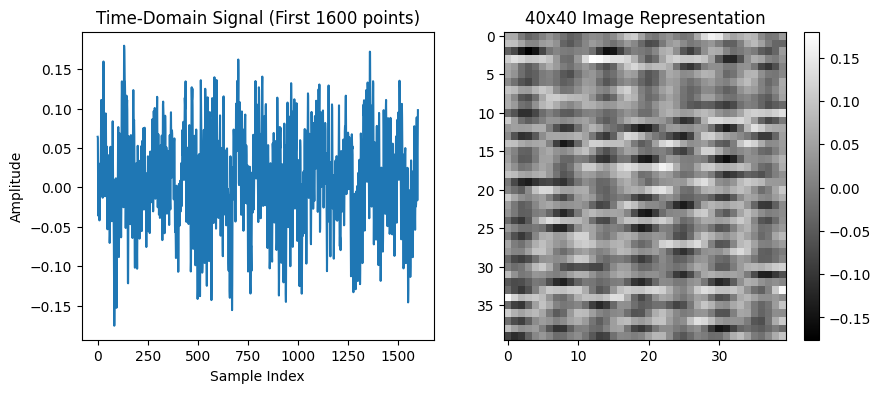

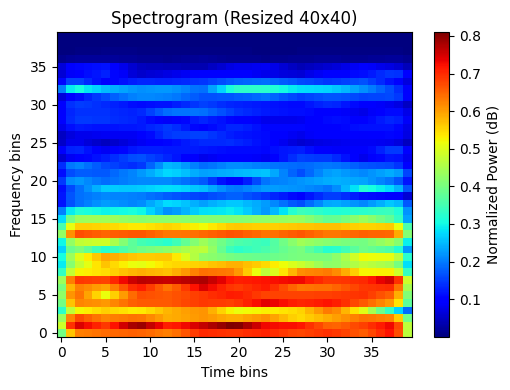

In [71]:
##Visualising normal form dataset of first 1600 data points(1 block) as a 40x40 image

import math 
from scipy import signal
# Load the data
data = scipy.io.loadmat('CWRU_BearingData_Load_2HP/99.mat')
signal_data = data['X099_DE_time'].flatten()

plt.figure(figsize=(15, 4))
plt.plot(signal_data)
plt.title('Full 1D Time-Series Signal - Healthy')
plt.xlabel('Sample Index')
plt.ylabel('Amplitude')
plt.show()

# Calculate max square size
length = len(signal_data)
side = int(math.sqrt(length))
trim_size = side * side

signal_trimmed = signal_data[:trim_size]

# Reshape
image1 = signal_trimmed.reshape((side, side))

# Plot image
plt.figure(figsize=(6, 6))
plt.imshow(image1, cmap='gray', aspect='auto')
plt.title(f'{side}x{side} Full 1D Image Representation')
plt.colorbar()
plt.show()

# Define segment size
segment_size = 40 * 40  # = 1600

# Extract the first segment
segment = signal_data[:segment_size]

# Reshape into a 40x40 image
image = segment.reshape((40, 40))

# Plot both time series and 40x40 image
plt.figure(figsize=(10, 4))

# Plot time-domain signal
plt.subplot(1, 2, 1)
plt.plot(segment)
plt.title('Time-Domain Signal (First 1600 points)')
plt.xlabel('Sample Index')
plt.ylabel('Amplitude')

# Plot image
plt.subplot(1, 2, 2)
plt.imshow(image, cmap='gray', aspect='auto')
plt.title('40x40 Image Representation')
plt.colorbar()



# Compute spectrogram of the segment
fs = 48000  # Sampling frequency

f, t, Sxx = signal.spectrogram(segment, fs=fs, nperseg=256, noverlap=128)

# Convert power spectrogram to dB scale and normalize
Sxx_db = 10 * np.log10(Sxx + 1e-10)
Sxx_norm = min_max_norm(Sxx_db)

# Resize spectrogram to 40x40 (optional, for CNN input consistency)
Sxx_resized = resize(Sxx_norm, (40, 40), mode='constant', anti_aliasing=True)

# Plot time series, image, and spectrogram side by side
plt.figure(figsize=(15, 4))

# Spectrogram plot
plt.subplot(1, 3, 3)
plt.imshow(Sxx_resized, cmap='jet', aspect='auto', origin='lower')
plt.title('Spectrogram (Resized 40x40)')
plt.xlabel('Time bins')
plt.ylabel('Frequency bins')
plt.colorbar(label='Normalized Power (dB)')

plt.tight_layout()
plt.show()


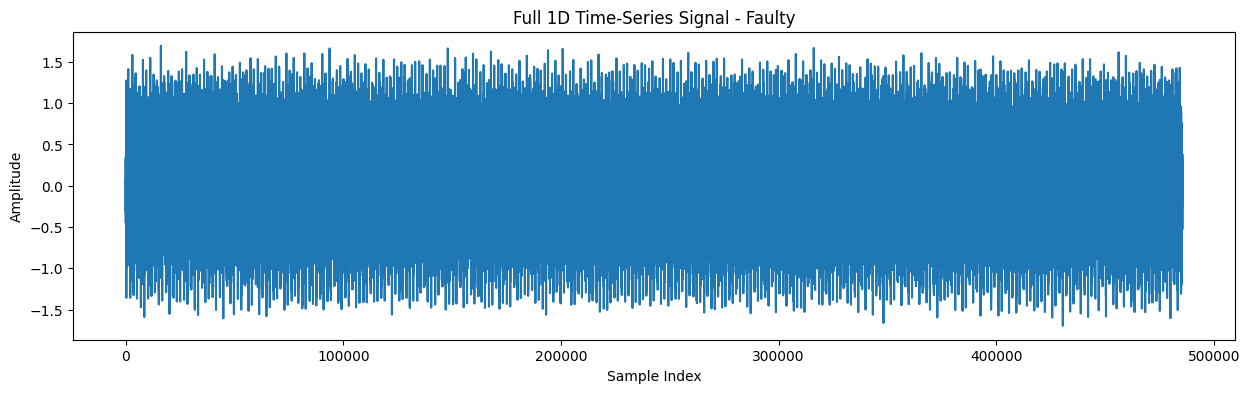

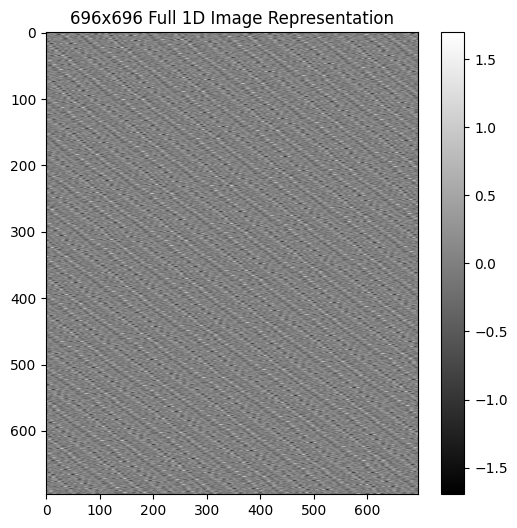

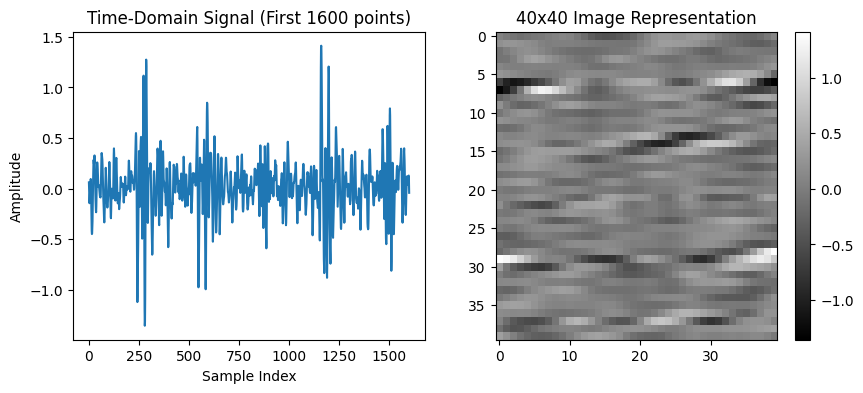

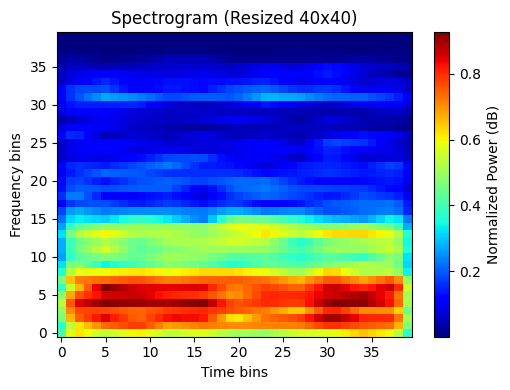

In [75]:
##Visualising InnerRac007 fault 111.mat dataset of first 1600 data points(1 block) as a 40x40 image
from scipy import signal
# Load the data
data = scipy.io.loadmat('CWRU_BearingData_Load_2HP/111.mat')
signal_data = data['X111_DE_time'].flatten()

plt.figure(figsize=(15, 4))
plt.plot(signal_data)
plt.title('Full 1D Time-Series Signal - Faulty')
plt.xlabel('Sample Index')
plt.ylabel('Amplitude')
plt.show()


# Calculate max square size
length = len(signal_data)
side = int(math.sqrt(length))
trim_size = side * side

signal_trimmed = signal_data[:trim_size]

# Reshape
image1 = signal_trimmed.reshape((side, side))

# Plot image
plt.figure(figsize=(6, 6))
plt.imshow(image1, cmap='gray', aspect='auto')
plt.title(f'{side}x{side} Full 1D Image Representation')
plt.colorbar()
plt.show()


# Define segment size
segment_size = 40 * 40  # = 1600

# Extract the first segment
segment = signal_data[:segment_size]

# Reshape into a 40x40 image
image = segment.reshape((40, 40))

# Plot both time series and 40x40 image
plt.figure(figsize=(10, 4))

# Plot time-domain signal
plt.subplot(1, 2, 1)
plt.plot(segment)
plt.title('Time-Domain Signal (First 1600 points)')
plt.xlabel('Sample Index')
plt.ylabel('Amplitude')

# Plot image
plt.subplot(1, 2, 2)
plt.imshow(image, cmap='gray', aspect='auto')
plt.title('40x40 Image Representation')
plt.colorbar()

# Compute spectrogram of the segment
fs = 48000  # Sampling frequency

f, t, Sxx = signal.spectrogram(segment, fs=fs, nperseg=256, noverlap=128)

# Convert power spectrogram to dB scale and normalize
Sxx_db = 10 * np.log10(Sxx + 1e-10)
Sxx_norm = min_max_norm(Sxx_db)

# Resize spectrogram to 40x40 (optional, for CNN input consistency)
Sxx_resized = resize(Sxx_norm, (40, 40), mode='constant', anti_aliasing=True)

# Plot time series, image, and spectrogram side by side
plt.figure(figsize=(15, 4))

# Spectrogram plot
plt.subplot(1, 3, 3)
plt.imshow(Sxx_resized, cmap='jet', aspect='auto', origin='lower')
plt.title('Spectrogram (Resized 40x40)')
plt.xlabel('Time bins')
plt.ylabel('Frequency bins')
plt.colorbar(label='Normalized Power (dB)')

plt.tight_layout()
plt.show()



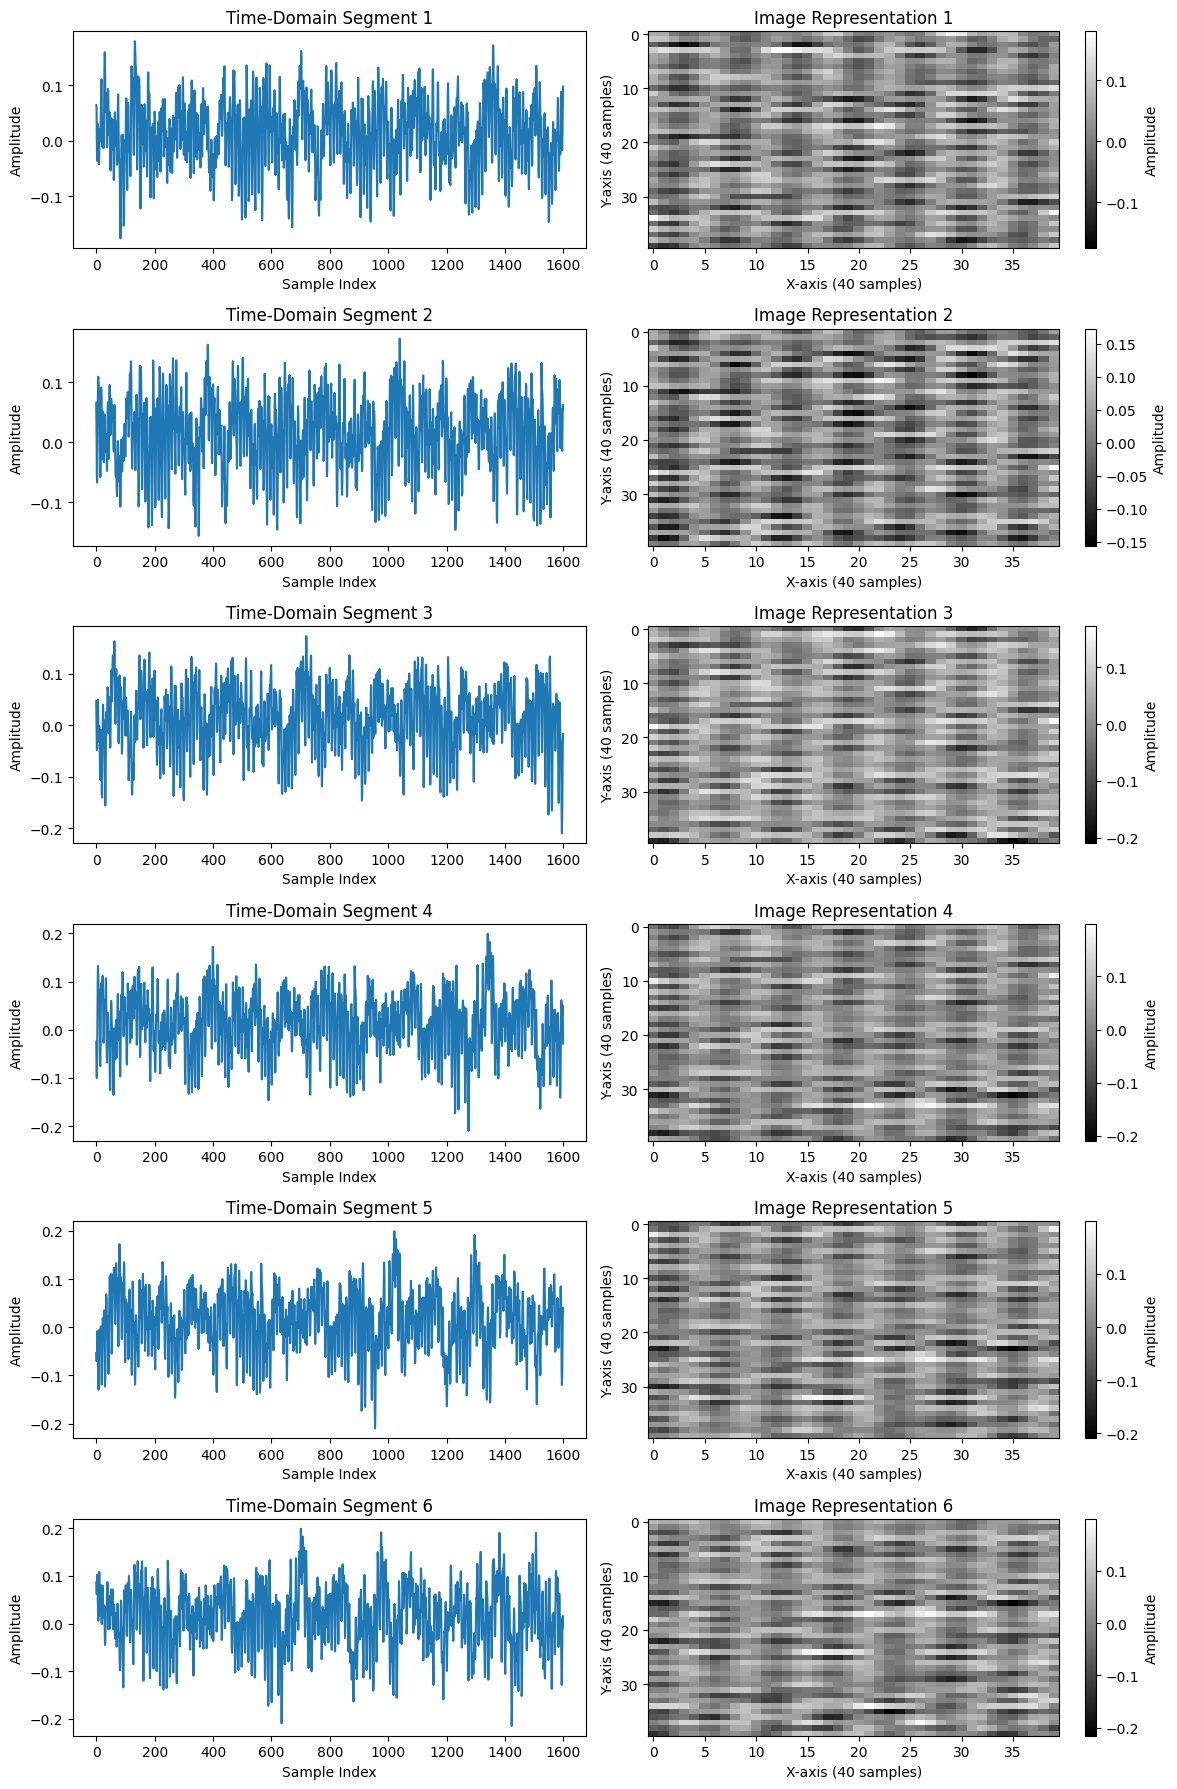

In [67]:
#Visualising the time-domain data along with overlapping segments 320 interval-len (first 6 batches)

import scipy.io
import numpy as np
import matplotlib.pyplot as plt

# Load the .mat file
mat_data = scipy.io.loadmat('CWRU_BearingData_Load_2HP/99.mat')
signal = mat_data['X099_DE_time'].flatten()

# Parameters
segment_size = 1600  # 40x40
step_size = 320

# Generate image segments and corresponding raw signals
def create_images_and_signals(signal, segment_size=1600, step=320, image_shape=(40, 40)):
    images = []
    raw_segments = []
    for i in range(0, len(signal) - segment_size + 1, step):
        segment = signal[i:i + segment_size]
        image = segment.reshape(image_shape)
        images.append(image)
        raw_segments.append(segment)
    return np.array(images), np.array(raw_segments)

# Create data
images, segments = create_images_and_signals(signal, segment_size, step_size)

# Plot the first 6 pairs (signal + image)
fig, axes = plt.subplots(6, 2, figsize=(12, 18))

for i in range(6):
    # Time-domain plot
    axes[i, 0].plot(segments[i])
    axes[i, 0].set_title(f'Time-Domain Segment {i+1}')
    axes[i, 0].set_xlabel('Sample Index')
    axes[i, 0].set_ylabel('Amplitude')

    # Image plot with axis and colorbar
    img = axes[i, 1].imshow(images[i], cmap='gray', aspect='auto')
    axes[i, 1].set_title(f'Image Representation {i+1}')
    axes[i, 1].set_xlabel('X-axis (40 samples)')
    axes[i, 1].set_ylabel('Y-axis (40 samples)')
    
    # Add colorbar
    cbar = plt.colorbar(img, ax=axes[i, 1])
    cbar.set_label('Amplitude')

plt.tight_layout()
plt.show()


In [106]:
"""
# -----------------------------------------------------------------------------
# Multiclass Classification CNN Model Training
# -----------------------------------------------------------------------------
"""

## 2-Dimensional Convolutional Neural Network Classification

# Reshape the data - 2 dimensional feed 
Input_2D = X.reshape([-1,40,40,1])

# Input_2D = X_image.reshape([-1,40,40,1])
print(Input_2D.shape)


(3026, 40, 40, 1)


In [107]:
# Test-Train Split 
X_2D_train, X_2D_test, y_2D_train, y_2D_test, y_label_train, y_label_test = train_test_split(Input_2D, Y_CNN, Y, train_size=0.8, test_size=0.2, random_state=42, stratify=Y)
#(ensuring class balance via stratify=Y)
# X_2D_train, X_2D_test, y_2D_train, y_2D_test = train_test_split(Input_2D, Y_CNN, train_size=0.8, test_size=0.2, random_state=42, shuffle=True)

# Define the CNN Classification model
class CNN_2D():
  def __init__(self):
    self.model = self.CreateModel()

  def CreateModel(self):
    model = models.Sequential([
        # layers.Conv2D(filters=16, kernel_size=(3,3), strides=(2,2), padding ='same',activation='relu'),
        layers.Conv2D(filters=16, kernel_size=(3,3), padding='same',activation='relu', input_shape=(40,40,1)),
        layers.MaxPool2D(pool_size=(2,2), padding='same'),
        layers.Conv2D(filters=32, kernel_size=(3,3), padding ='same',activation='relu'),
        layers.MaxPool2D(pool_size=(2,2), padding='same'),
        layers.Conv2D(filters=64, kernel_size=(3,3),padding ='same', activation='relu'),
        layers.MaxPool2D(pool_size=(2,2), padding='same'),
        layers.Conv2D(filters=128, kernel_size=(3,3),padding ='same', activation='relu'),
        layers.MaxPool2D(pool_size=(2,2), padding='same'),
        layers.Flatten(),
        layers.Dense(100,activation='relu'),
        layers.Dense(50,activation='relu'),
        layers.Dense(10),
        layers.Softmax()
        ])
    model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])
    return model

In [79]:
# k-fold cross validation / 5 fold cross validation )
kSplits = 5
# kfold = KFold(n_splits=kSplits, random_state=42, shuffle=True)
kfold = StratifiedKFold(n_splits=kSplits, random_state=42, shuffle=True) # splits training data into 5 folds - class balance(stratify)

# File path name to save best models
foldername = "CNN2D_results/V4_2_NOL_exp1/"

from tensorflow.keras.callbacks import ModelCheckpoint #Saves the model with the highest validation accuracy for each fold
from tensorflow.keras.callbacks import EarlyStopping 
from tensorflow.keras.models import load_model 

accuracy_train = []
accuracy_val = []
accuracy_test = []
pred_all_val = np.zeros([len(X_2D_train),10])
y_2D_val = np.zeros([len(X_2D_train),10])
kfold_test_len = []

fl1 = 0
k = 1

early_stop = EarlyStopping(monitor='val_accuracy', patience=50, restore_best_weights=True) #Stops training if validation accuracy doesn’t improve for 50 epochs, restoring the best weights.

# Train the model 
# for train, test in kfold.split(X_2D_train,y_2D_train):
for fold, (train, test) in enumerate(kfold.split(X_2D_train, y_label_train)):   

  # Define where to save the best model
  checkpoint_filepath = foldername + "best_model_" + str(k) + ".h5"
    
  # Create a ModelCheckpoint callback
  checkpoint = ModelCheckpoint(
      filepath=checkpoint_filepath,
      monitor='val_accuracy',  # Monitor validation accuracy
      save_best_only=True,  # Save only the best model
      mode='max',  # Maximize accuracy
      verbose=1
  )        

#For each fold, trains a new CNN model on the training subset (X_2D_train[train], y_2D_train[train]) for up to 200 epochs.
  Classification_2D = CNN_2D()
  # history = Classification_2D.model.fit(X_2D_train[train], y_2D_train[train], verbose=1, epochs=50) #epochs=12
  history = Classification_2D.model.fit(
        X_2D_train[train], y_2D_train[train],
        validation_data=(X_2D_train[test], y_2D_train[test]),  # Validation set for monitoring
        epochs=200,
        verbose=1,
        callbacks=[checkpoint, early_stop]  # Save the best model
  )
  
  print("Best model saved at:", checkpoint_filepath)
  CNN_2D_best_model = load_model(checkpoint_filepath)
  print("Best model loaded successfully!")
  
  fl2 = fl1 + len(test)
  pred_all_val[fl1:fl2,:] = CNN_2D_best_model.predict(X_2D_train[test])
  y_2D_val[fl1:fl2,:] = y_2D_train[test]
  kfold_test_len.append(fl2-fl1)
  fl1 = fl2  

  # Evaluate the accuracy of the model on the training set 
  train_loss, train_accuracy = CNN_2D_best_model.evaluate(X_2D_train[train], y_2D_train[train]) 
  accuracy_train.append(train_accuracy)
  
  # Evaluate the accuracy of the model on the validation set 
  val_loss, val_accuracy = CNN_2D_best_model.evaluate(X_2D_train[test], y_2D_train[test]) 
  accuracy_val.append(val_accuracy)
  
  # Evaluate the accuracy of the model on the validation set 
  test_loss, test_accuracy = CNN_2D_best_model.evaluate(X_2D_test, y_2D_test) 
  accuracy_test.append(test_accuracy)  
  
  # Evaluate the accuracy of the model on the training set 
  # kf_loss, kf_accuracy = Classification_2D.model.evaluate(X_2D_train[test], y_2D_train[test]) 
  # accuracy_2D.append(kf_accuracy)
  
  k = k + 1

Epoch 1/200


/Users/Gayathri/pyenvs/tf-env/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-06-05 13:35:49.047905: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown a

60/61 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.2134 - loss: 2.0649
Epoch 1: val_accuracy improved from -inf to 0.52686, saving model to CNN2D_results/V4_2_NOL_exp1/best_model_1.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - accuracy: 0.2175 - loss: 2.0558 - val_accuracy: 0.5269 - val_loss: 1.3231
Epoch 2/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.5768 - loss: 1.1386
Epoch 2: val_accuracy improved from 0.52686 to 0.77479, saving model to CNN2D_results/V4_2_NOL_exp1/best_model_1.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - accuracy: 0.5780 - loss: 1.1349 - val_accuracy: 0.7748 - val_loss: 0.6351
Epoch 3/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.7552 - loss: 0.6268
Epoch 3: val_accuracy improved from 0.77479 to 0.81612, saving model to CNN2D_results/V4_2_NOL_exp1/best_model_1.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.7558 - loss: 0.6252 - val_accuracy: 0.8161 - val_loss: 0.4049
Epoch 4/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.8417 - loss: 0.3916
Epoch 4: val_accuracy improved from 0.81612 to 0.84917, saving model to CNN2D_results/V4_2_NOL_exp1/best_model_1.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.8418 - loss: 0.3912 - val_accuracy: 0.8492 - val_loss: 0.3308
Epoch 5/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.8561 - loss: 0.3299
Epoch 5: val_accuracy improved from 0.84917 to 0.85950, saving model to CNN2D_results/V4_2_NOL_exp1/best_model_1.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.8563 - loss: 0.3298 - val_accuracy: 0.8595 - val_loss: 0.3272
Epoch 6/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.8651 - loss: 0.2975
Epoch 6: val_accuracy improved from 0.85950 to 0.87603, saving model to CNN2D_results/V4_2_NOL_exp1/best_model_1.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.8652 - loss: 0.2973 - val_accuracy: 0.8760 - val_loss: 0.2641
Epoch 7/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.8946 - loss: 0.2559
Epoch 7: val_accuracy improved from 0.87603 to 0.88636, saving model to CNN2D_results/V4_2_NOL_exp1/best_model_1.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.8947 - loss: 0.2557 - val_accuracy: 0.8864 - val_loss: 0.2680
Epoch 8/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.9078 - loss: 0.2176
Epoch 8: val_accuracy improved from 0.88636 to 0.88843, saving model to CNN2D_results/V4_2_NOL_exp1/best_model_1.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.9079 - loss: 0.2175 - val_accuracy: 0.8884 - val_loss: 0.2732
Epoch 9/200
60/61 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.9061 - loss: 0.2078
Epoch 9: val_accuracy did not improve from 0.88843
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.9061 - loss: 0.2079 - val_accuracy: 0.8781 - val_loss: 0.2847
Epoch 10/200
59/61 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.9031 - loss: 0.2203
Epoch 10: val_accuracy did not improve from 0.88843
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.9036 - loss: 0.2193 - val_accuracy: 0.7955 - val_loss: 0.6077
Epoch 11/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.9072 - loss: 0.2237
Epoch 11: val_accuracy did not improve from 0.88843
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.9074 - loss: 0.2233 - val_accuracy: 0.8802 - val_loss: 0.2797
Epoch 12/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.9120 - loss: 0.1946
Epoch 12: val_accuracy did not imp

61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.9169 - loss: 0.2005 - val_accuracy: 0.8967 - val_loss: 0.2382
Epoch 14/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.9313 - loss: 0.1840
Epoch 14: val_accuracy did not improve from 0.89669
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.9312 - loss: 0.1842 - val_accuracy: 0.8843 - val_loss: 0.3128
Epoch 15/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.9381 - loss: 0.1453
Epoch 15: val_accuracy did not improve from 0.89669
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.9382 - loss: 0.1451 - val_accuracy: 0.8471 - val_loss: 0.4263
Epoch 16/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.9163 - loss: 0.1879
Epoch 16: val_accuracy improved from 0.89669 to 0.92149, saving model to CNN2D_results/V4_2_NOL_exp1/best_model_1.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 0.9166 - loss: 0.1874 - val_accuracy: 0.9215 - val_loss: 0.1696
Epoch 17/200
59/61 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.9465 - loss: 0.1222
Epoch 17: val_accuracy did not improve from 0.92149
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.9467 - loss: 0.1217 - val_accuracy: 0.9050 - val_loss: 0.2485
Epoch 18/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.9422 - loss: 0.1388
Epoch 18: val_accuracy did not improve from 0.92149
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.9424 - loss: 0.1383 - val_accuracy: 0.9153 - val_loss: 0.2170
Epoch 19/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.9563 - loss: 0.1127
Epoch 19: val_accuracy did not improve from 0.92149
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.9564 - loss: 0.1125 - val_accuracy: 0.9070 - val_loss: 0.2328
Epoch 20/200
60/61 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.9535 - loss: 0.1148
Epoch 20: val_accuracy improved 

61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - accuracy: 0.9537 - loss: 0.1142 - val_accuracy: 0.9318 - val_loss: 0.1455
Epoch 21/200
59/61 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.9589 - loss: 0.0975
Epoch 21: val_accuracy improved from 0.93182 to 0.96488, saving model to CNN2D_results/V4_2_NOL_exp1/best_model_1.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.9588 - loss: 0.0979 - val_accuracy: 0.9649 - val_loss: 0.1301
Epoch 22/200
59/61 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.9811 - loss: 0.0616
Epoch 22: val_accuracy did not improve from 0.96488
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.9809 - loss: 0.0620 - val_accuracy: 0.9504 - val_loss: 0.1944
Epoch 23/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.9765 - loss: 0.0620
Epoch 23: val_accuracy did not improve from 0.96488
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.9765 - loss: 0.0621 - val_accuracy: 0.9525 - val_loss: 0.2035
Epoch 24/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.9714 - loss: 0.0736
Epoch 24: val_accuracy improved from 0.96488 to 0.97727, saving model to CNN2D_results/V4_2_NOL_exp1/best_model_1.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.9714 - loss: 0.0735 - val_accuracy: 0.9773 - val_loss: 0.0628
Epoch 25/200
59/61 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.9842 - loss: 0.0408
Epoch 25: val_accuracy improved from 0.97727 to 0.98140, saving model to CNN2D_results/V4_2_NOL_exp1/best_model_1.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.9843 - loss: 0.0407 - val_accuracy: 0.9814 - val_loss: 0.0595
Epoch 26/200
60/61 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.9878 - loss: 0.0244
Epoch 26: val_accuracy did not improve from 0.98140
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.9879 - loss: 0.0245 - val_accuracy: 0.9690 - val_loss: 0.0759
Epoch 27/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.9939 - loss: 0.0211
Epoch 27: val_accuracy did not improve from 0.98140
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.9939 - loss: 0.0211 - val_accuracy: 0.9752 - val_loss: 0.0610
Epoch 28/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.9901 - loss: 0.0278
Epoch 28: val_accuracy improved from 0.98140 to 0.98967, saving model to CNN2D_results/V4_2_NOL_exp1/best_model_1.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.9901 - loss: 0.0277 - val_accuracy: 0.9897 - val_loss: 0.0430
Epoch 29/200
60/61 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.9998 - loss: 0.0067
Epoch 29: val_accuracy did not improve from 0.98967
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.9998 - loss: 0.0067 - val_accuracy: 0.9711 - val_loss: 0.0790
Epoch 30/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.9961 - loss: 0.0109
Epoch 30: val_accuracy did not improve from 0.98967
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.9961 - loss: 0.0109 - val_accuracy: 0.9607 - val_loss: 0.1062
Epoch 31/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.9921 - loss: 0.0179
Epoch 31: val_accuracy did not improve from 0.98967
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.9921 - loss: 0.0181 - val_accuracy: 0.9463 - val_loss: 0.1261
Epoch 32/200
60/61 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.9830 - loss: 0.0403
Epoch 32: val_accuracy did not i

61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 1.0000 - loss: 0.0012 - val_accuracy: 0.9938 - val_loss: 0.0286
Epoch 43/200
59/61 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 1.0000 - loss: 6.4240e-04
Epoch 43: val_accuracy did not improve from 0.99380
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 1.0000 - loss: 6.3763e-04 - val_accuracy: 0.9917 - val_loss: 0.0270
Epoch 44/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 1.0000 - loss: 5.2055e-04
Epoch 44: val_accuracy did not improve from 0.99380
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 1.0000 - loss: 5.1943e-04 - val_accuracy: 0.9917 - val_loss: 0.0269
Epoch 45/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 1.0000 - loss: 4.8711e-04
Epoch 45: val_accuracy did not improve from 0.99380
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 1.0000 - loss: 4.8577e-04 - val_accuracy: 0.9917 - val_loss: 0.0270
Epoch 46/200
60/61 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 1.0000 - loss: 4.3580e-04
Epoc

Best model loaded successfully!
 1/16 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step

2025-06-05 13:39:19.944338: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-06-05 13:39:19.945173: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 1.0000 - loss: 5.2811e-04
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9918 - loss: 0.0354
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9813 - loss: 0.0822
Epoch 1/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.1883 - loss: 1.9593
Epoch 1: val_accuracy improved from -inf to 0.61983, saving model to CNN2D_results/V4_2_NOL_exp1/best_model_2.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - accuracy: 0.1906 - loss: 1.9551 - val_accuracy: 0.6198 - val_loss: 1.1641
Epoch 2/200
59/61 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.6376 - loss: 0.9783
Epoch 2: val_accuracy improved from 0.61983 to 0.79339, saving model to CNN2D_results/V4_2_NOL_exp1/best_model_2.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.6402 - loss: 0.9715 - val_accuracy: 0.7934 - val_loss: 0.5180
Epoch 3/200
59/61 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.8007 - loss: 0.4741
Epoch 3: val_accuracy did not improve from 0.79339
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.8014 - loss: 0.4724 - val_accuracy: 0.7934 - val_loss: 0.4855
Epoch 4/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.8441 - loss: 0.3349
Epoch 4: val_accuracy did not improve from 0.79339
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.8439 - loss: 0.3354 - val_accuracy: 0.7459 - val_loss: 0.6399
Epoch 5/200
60/61 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.8327 - loss: 0.3730
Epoch 5: val_accuracy improved from 0.79339 to 0.82231, saving model to CNN2D_results/V4_2_NOL_exp1/best_model_2.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 0.8328 - loss: 0.3731 - val_accuracy: 0.8223 - val_loss: 0.3701
Epoch 6/200
59/61 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.8543 - loss: 0.2931
Epoch 6: val_accuracy did not improve from 0.82231
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.8550 - loss: 0.2924 - val_accuracy: 0.8140 - val_loss: 0.4506
Epoch 7/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.8754 - loss: 0.2665
Epoch 7: val_accuracy did not improve from 0.82231
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.8752 - loss: 0.2668 - val_accuracy: 0.7996 - val_loss: 0.4692
Epoch 8/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.8513 - loss: 0.3127
Epoch 8: val_accuracy improved from 0.82231 to 0.84091, saving model to CNN2D_results/V4_2_NOL_exp1/best_model_2.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.8515 - loss: 0.3121 - val_accuracy: 0.8409 - val_loss: 0.3782
Epoch 9/200
59/61 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.8635 - loss: 0.2620
Epoch 9: val_accuracy improved from 0.84091 to 0.86983, saving model to CNN2D_results/V4_2_NOL_exp1/best_model_2.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.8637 - loss: 0.2614 - val_accuracy: 0.8698 - val_loss: 0.3351
Epoch 10/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.8669 - loss: 0.2977
Epoch 10: val_accuracy did not improve from 0.86983
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.8669 - loss: 0.2979 - val_accuracy: 0.8636 - val_loss: 0.2806
Epoch 11/200
60/61 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.9041 - loss: 0.1913
Epoch 11: val_accuracy improved from 0.86983 to 0.88017, saving model to CNN2D_results/V4_2_NOL_exp1/best_model_2.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 0.9041 - loss: 0.1912 - val_accuracy: 0.8802 - val_loss: 0.2481
Epoch 12/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.9092 - loss: 0.1676
Epoch 12: val_accuracy did not improve from 0.88017
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - accuracy: 0.9091 - loss: 0.1677 - val_accuracy: 0.8740 - val_loss: 0.2306
Epoch 13/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.9121 - loss: 0.1556
Epoch 13: val_accuracy improved from 0.88017 to 0.88843, saving model to CNN2D_results/V4_2_NOL_exp1/best_model_2.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.9121 - loss: 0.1558 - val_accuracy: 0.8884 - val_loss: 0.2312
Epoch 14/200
59/61 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.9213 - loss: 0.1505
Epoch 14: val_accuracy improved from 0.88843 to 0.91322, saving model to CNN2D_results/V4_2_NOL_exp1/best_model_2.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.9211 - loss: 0.1508 - val_accuracy: 0.9132 - val_loss: 0.2366
Epoch 15/200
59/61 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.9268 - loss: 0.1359
Epoch 15: val_accuracy improved from 0.91322 to 0.92149, saving model to CNN2D_results/V4_2_NOL_exp1/best_model_2.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.9268 - loss: 0.1360 - val_accuracy: 0.9215 - val_loss: 0.2299
Epoch 16/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.9333 - loss: 0.1290
Epoch 16: val_accuracy did not improve from 0.92149
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.9331 - loss: 0.1296 - val_accuracy: 0.8760 - val_loss: 0.3412
Epoch 17/200
60/61 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.8953 - loss: 0.2163
Epoch 17: val_accuracy did not improve from 0.92149
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.8957 - loss: 0.2161 - val_accuracy: 0.9153 - val_loss: 0.2243
Epoch 18/200
59/61 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.8904 - loss: 0.2154
Epoch 18: val_accuracy improved from 0.92149 to 0.92355, saving model to CNN2D_results/V4_2_NOL_exp1/best_model_2.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.8904 - loss: 0.2159 - val_accuracy: 0.9236 - val_loss: 0.2156
Epoch 19/200
59/61 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.9146 - loss: 0.1588
Epoch 19: val_accuracy improved from 0.92355 to 0.93182, saving model to CNN2D_results/V4_2_NOL_exp1/best_model_2.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.9152 - loss: 0.1583 - val_accuracy: 0.9318 - val_loss: 0.2159
Epoch 20/200
59/61 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.9454 - loss: 0.1124
Epoch 20: val_accuracy did not improve from 0.93182
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.9453 - loss: 0.1126 - val_accuracy: 0.9070 - val_loss: 0.1910
Epoch 21/200
59/61 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.9531 - loss: 0.0947
Epoch 21: val_accuracy did not improve from 0.93182
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.9532 - loss: 0.0947 - val_accuracy: 0.9070 - val_loss: 0.1970
Epoch 22/200
59/61 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.9517 - loss: 0.0908
Epoch 22: val_accuracy did not improve from 0.93182
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.9521 - loss: 0.0904 - val_accuracy: 0.9029 - val_loss: 0.2151
Epoch 23/200
59/61 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.9628 - loss: 0.0739
Epoch 23: val_accuracy did not i

61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.9748 - loss: 0.0627 - val_accuracy: 0.9504 - val_loss: 0.1854
Epoch 28/200
59/61 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.9428 - loss: 0.1597
Epoch 28: val_accuracy did not improve from 0.95041
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.9422 - loss: 0.1615 - val_accuracy: 0.9008 - val_loss: 0.3096
Epoch 29/200
60/61 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.9515 - loss: 0.1377
Epoch 29: val_accuracy improved from 0.95041 to 0.95248, saving model to CNN2D_results/V4_2_NOL_exp1/best_model_2.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.9521 - loss: 0.1363 - val_accuracy: 0.9525 - val_loss: 0.1545
Epoch 30/200
60/61 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.9923 - loss: 0.0266
Epoch 30: val_accuracy did not improve from 0.95248
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 0.9924 - loss: 0.0264 - val_accuracy: 0.9463 - val_loss: 0.1573
Epoch 31/200
60/61 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.9945 - loss: 0.0220
Epoch 31: val_accuracy did not improve from 0.95248
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.9945 - loss: 0.0218 - val_accuracy: 0.9463 - val_loss: 0.1896
Epoch 32/200
59/61 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.9973 - loss: 0.0188
Epoch 32: val_accuracy did not improve from 0.95248
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.9972 - loss: 0.0187 - val_accuracy: 0.9442 - val_loss: 0.2071
Epoch 33/200
59/61 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.9903 - loss: 0.0269
Epoch 33: val_accuracy did not i

61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - accuracy: 0.9991 - loss: 0.0109 - val_accuracy: 0.9607 - val_loss: 0.1092
Epoch 39/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 1.0000 - loss: 0.0050
Epoch 39: val_accuracy improved from 0.96074 to 0.96488, saving model to CNN2D_results/V4_2_NOL_exp1/best_model_2.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 1.0000 - loss: 0.0050 - val_accuracy: 0.9649 - val_loss: 0.1140
Epoch 40/200
59/61 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 1.0000 - loss: 0.0020
Epoch 40: val_accuracy did not improve from 0.96488
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 1.0000 - loss: 0.0020 - val_accuracy: 0.9628 - val_loss: 0.1235
Epoch 41/200
59/61 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 1.0000 - loss: 0.0014
Epoch 41: val_accuracy did not improve from 0.96488
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 1.0000 - loss: 0.0014 - val_accuracy: 0.9628 - val_loss: 0.1274
Epoch 42/200
60/61 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 1.0000 - loss: 9.8138e-04
Epoch 42: val_accuracy did not improve from 0.96488
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 1.0000 - loss: 9.7568e-04 - val_accuracy: 0.9628 - val_loss: 0.1303
Epoch 43/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 1.0000 - loss: 7.5660e-04
Epoch 43: val_accura

61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 1.0000 - loss: 7.5462e-04 - val_accuracy: 0.9669 - val_loss: 0.1325
Epoch 44/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 1.0000 - loss: 6.0943e-04
Epoch 44: val_accuracy did not improve from 0.96694
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 1.0000 - loss: 6.0795e-04 - val_accuracy: 0.9669 - val_loss: 0.1341
Epoch 45/200
59/61 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 1.0000 - loss: 5.0752e-04
Epoch 45: val_accuracy did not improve from 0.96694
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 1.0000 - loss: 5.0394e-04 - val_accuracy: 0.9669 - val_loss: 0.1362
Epoch 46/200
59/61 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 1.0000 - loss: 4.2429e-04
Epoch 46: val_accuracy did not improve from 0.96694
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 1.0000 - loss: 4.2150e-04 - val_accuracy: 0.9649 - val_loss: 0.1375
Epoch 47/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 1.0000 - loss: 3.6034e-04


Best model loaded successfully!
 6/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

2025-06-05 13:42:47.365765: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-06-05 13:42:47.367960: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 1.0000 - loss: 5.0402e-04
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9748 - loss: 0.0866
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9863 - loss: 0.0530
Epoch 1/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.2222 - loss: 1.9918
Epoch 1: val_accuracy improved from -inf to 0.64669, saving model to CNN2D_results/V4_2_NOL_exp1/best_model_3.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - accuracy: 0.2248 - loss: 1.9877 - val_accuracy: 0.6467 - val_loss: 1.0585
Epoch 2/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.6522 - loss: 0.9547
Epoch 2: val_accuracy improved from 0.64669 to 0.77686, saving model to CNN2D_results/V4_2_NOL_exp1/best_model_3.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 0.6526 - loss: 0.9532 - val_accuracy: 0.7769 - val_loss: 0.5158
Epoch 3/200
60/61 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.8143 - loss: 0.4484
Epoch 3: val_accuracy improved from 0.77686 to 0.82438, saving model to CNN2D_results/V4_2_NOL_exp1/best_model_3.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - accuracy: 0.8142 - loss: 0.4488 - val_accuracy: 0.8244 - val_loss: 0.3801
Epoch 4/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.8280 - loss: 0.3981
Epoch 4: val_accuracy improved from 0.82438 to 0.85537, saving model to CNN2D_results/V4_2_NOL_exp1/best_model_3.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - accuracy: 0.8280 - loss: 0.3980 - val_accuracy: 0.8554 - val_loss: 0.3372
Epoch 5/200
60/61 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.8471 - loss: 0.3309
Epoch 5: val_accuracy did not improve from 0.85537
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.8469 - loss: 0.3314 - val_accuracy: 0.8244 - val_loss: 0.4386
Epoch 6/200
60/61 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.8463 - loss: 0.3242
Epoch 6: val_accuracy did not improve from 0.85537
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 0.8463 - loss: 0.3245 - val_accuracy: 0.8264 - val_loss: 0.4488
Epoch 7/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.8456 - loss: 0.3431
Epoch 7: val_accuracy improved from 0.85537 to 0.87810, saving model to CNN2D_results/V4_2_NOL_exp1/best_model_3.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.8457 - loss: 0.3430 - val_accuracy: 0.8781 - val_loss: 0.3136
Epoch 8/200
60/61 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.8698 - loss: 0.2760
Epoch 8: val_accuracy improved from 0.87810 to 0.89256, saving model to CNN2D_results/V4_2_NOL_exp1/best_model_3.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - accuracy: 0.8699 - loss: 0.2759 - val_accuracy: 0.8926 - val_loss: 0.2468
Epoch 9/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.8868 - loss: 0.2520
Epoch 9: val_accuracy improved from 0.89256 to 0.89463, saving model to CNN2D_results/V4_2_NOL_exp1/best_model_3.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.8868 - loss: 0.2519 - val_accuracy: 0.8946 - val_loss: 0.2280
Epoch 10/200
59/61 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.8996 - loss: 0.2053
Epoch 10: val_accuracy improved from 0.89463 to 0.89669, saving model to CNN2D_results/V4_2_NOL_exp1/best_model_3.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.8996 - loss: 0.2063 - val_accuracy: 0.8967 - val_loss: 0.2377
Epoch 11/200
59/61 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.9044 - loss: 0.2178
Epoch 11: val_accuracy improved from 0.89669 to 0.90083, saving model to CNN2D_results/V4_2_NOL_exp1/best_model_3.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.9047 - loss: 0.2174 - val_accuracy: 0.9008 - val_loss: 0.2505
Epoch 12/200
60/61 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.9112 - loss: 0.1865
Epoch 12: val_accuracy improved from 0.90083 to 0.90289, saving model to CNN2D_results/V4_2_NOL_exp1/best_model_3.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.9113 - loss: 0.1864 - val_accuracy: 0.9029 - val_loss: 0.2154
Epoch 13/200
60/61 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.9014 - loss: 0.2187
Epoch 13: val_accuracy improved from 0.90289 to 0.91116, saving model to CNN2D_results/V4_2_NOL_exp1/best_model_3.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.9015 - loss: 0.2181 - val_accuracy: 0.9112 - val_loss: 0.2014
Epoch 14/200
59/61 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.9227 - loss: 0.1684
Epoch 14: val_accuracy did not improve from 0.91116
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.9227 - loss: 0.1682 - val_accuracy: 0.9070 - val_loss: 0.1880
Epoch 15/200
59/61 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.9253 - loss: 0.1459
Epoch 15: val_accuracy improved from 0.91116 to 0.91529, saving model to CNN2D_results/V4_2_NOL_exp1/best_model_3.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.9257 - loss: 0.1456 - val_accuracy: 0.9153 - val_loss: 0.2247
Epoch 16/200
60/61 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.9399 - loss: 0.1291
Epoch 16: val_accuracy did not improve from 0.91529
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - accuracy: 0.9402 - loss: 0.1288 - val_accuracy: 0.9029 - val_loss: 0.2864
Epoch 17/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.9453 - loss: 0.1266
Epoch 17: val_accuracy improved from 0.91529 to 0.93182, saving model to CNN2D_results/V4_2_NOL_exp1/best_model_3.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.9454 - loss: 0.1264 - val_accuracy: 0.9318 - val_loss: 0.1826
Epoch 18/200
59/61 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.9582 - loss: 0.1180
Epoch 18: val_accuracy did not improve from 0.93182
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.9581 - loss: 0.1181 - val_accuracy: 0.8554 - val_loss: 0.4342
Epoch 19/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.9379 - loss: 0.1630
Epoch 19: val_accuracy improved from 0.93182 to 0.96074, saving model to CNN2D_results/V4_2_NOL_exp1/best_model_3.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.9381 - loss: 0.1623 - val_accuracy: 0.9607 - val_loss: 0.0985
Epoch 20/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.9597 - loss: 0.1097
Epoch 20: val_accuracy did not improve from 0.96074
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - accuracy: 0.9596 - loss: 0.1102 - val_accuracy: 0.9277 - val_loss: 0.2205
Epoch 21/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.9684 - loss: 0.0911
Epoch 21: val_accuracy did not improve from 0.96074
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.9684 - loss: 0.0911 - val_accuracy: 0.9525 - val_loss: 0.1402
Epoch 22/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.9712 - loss: 0.0701
Epoch 22: val_accuracy did not improve from 0.96074
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.9712 - loss: 0.0701 - val_accuracy: 0.9339 - val_loss: 0.1573
Epoch 23/200
59/61 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.9828 - loss: 0.0624
Epoch 23: val_accuracy did not i

61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.9823 - loss: 0.0488 - val_accuracy: 0.9669 - val_loss: 0.0819
Epoch 25/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.9881 - loss: 0.0375
Epoch 25: val_accuracy did not improve from 0.96694
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.9881 - loss: 0.0375 - val_accuracy: 0.9277 - val_loss: 0.1986
Epoch 26/200
59/61 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.9793 - loss: 0.0558
Epoch 26: val_accuracy did not improve from 0.96694
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.9790 - loss: 0.0565 - val_accuracy: 0.9669 - val_loss: 0.1103
Epoch 27/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.9670 - loss: 0.0812
Epoch 27: val_accuracy did not improve from 0.96694
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.9670 - loss: 0.0811 - val_accuracy: 0.9607 - val_loss: 0.1133
Epoch 28/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.9639 - loss: 0.1094
Epoch 28: val_accuracy did not i

61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.9949 - loss: 0.0173 - val_accuracy: 0.9814 - val_loss: 0.0584
Epoch 35/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.9955 - loss: 0.0151
Epoch 35: val_accuracy improved from 0.98140 to 0.98347, saving model to CNN2D_results/V4_2_NOL_exp1/best_model_3.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.9956 - loss: 0.0151 - val_accuracy: 0.9835 - val_loss: 0.0456
Epoch 36/200
59/61 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.9987 - loss: 0.0048
Epoch 36: val_accuracy did not improve from 0.98347
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.9987 - loss: 0.0049 - val_accuracy: 0.9587 - val_loss: 0.1218
Epoch 37/200
59/61 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.9970 - loss: 0.0121
Epoch 37: val_accuracy did not improve from 0.98347
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.9969 - loss: 0.0121 - val_accuracy: 0.9793 - val_loss: 0.0566
Epoch 38/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.9996 - loss: 0.0039
Epoch 38: val_accuracy improved from 0.98347 to 0.98967, saving model to CNN2D_results/V4_2_NOL_exp1/best_model_3.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.9996 - loss: 0.0040 - val_accuracy: 0.9897 - val_loss: 0.0481
Epoch 39/200
59/61 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.9952 - loss: 0.0136
Epoch 39: val_accuracy did not improve from 0.98967
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.9952 - loss: 0.0137 - val_accuracy: 0.9773 - val_loss: 0.0750
Epoch 40/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 1.0000 - loss: 0.0022
Epoch 40: val_accuracy did not improve from 0.98967
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 1.0000 - loss: 0.0022 - val_accuracy: 0.9855 - val_loss: 0.0454
Epoch 41/200
59/61 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 1.0000 - loss: 5.8900e-04
Epoch 41: val_accuracy did not improve from 0.98967
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 1.0000 - loss: 5.8870e-04 - val_accuracy: 0.9855 - val_loss: 0.0456
Epoch 42/200
59/61 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 1.0000 - loss: 4.2099e-04
Epoch 42: val_accura

Best model saved at: CNN2D_results/V4_2_NOL_exp1/best_model_3.h5
Best model loaded successfully!


2025-06-05 13:46:10.299079: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-06-05 13:46:10.300005: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 1.0000 - loss: 8.6982e-04
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9921 - loss: 0.0398
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9799 - loss: 0.0799
Epoch 1/200
60/61 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.1808 - loss: 2.0784
Epoch 1: val_accuracy improved from -inf to 0.57851, saving model to CNN2D_results/V4_2_NOL_exp1/best_model_4.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.1850 - loss: 2.0709 - val_accuracy: 0.5785 - val_loss: 1.2226
Epoch 2/200
59/61 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.6290 - loss: 1.0436
Epoch 2: val_accuracy improved from 0.57851 to 0.69628, saving model to CNN2D_results/V4_2_NOL_exp1/best_model_4.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.6302 - loss: 1.0371 - val_accuracy: 0.6963 - val_loss: 0.7880
Epoch 3/200
60/61 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.6891 - loss: 0.7450
Epoch 3: val_accuracy improved from 0.69628 to 0.72314, saving model to CNN2D_results/V4_2_NOL_exp1/best_model_4.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - accuracy: 0.6905 - loss: 0.7423 - val_accuracy: 0.7231 - val_loss: 0.7531
Epoch 4/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.7708 - loss: 0.6131
Epoch 4: val_accuracy improved from 0.72314 to 0.81405, saving model to CNN2D_results/V4_2_NOL_exp1/best_model_4.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.7710 - loss: 0.6124 - val_accuracy: 0.8140 - val_loss: 0.4174
Epoch 5/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.8508 - loss: 0.3719
Epoch 5: val_accuracy improved from 0.81405 to 0.82231, saving model to CNN2D_results/V4_2_NOL_exp1/best_model_4.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.8506 - loss: 0.3719 - val_accuracy: 0.8223 - val_loss: 0.4112
Epoch 6/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.8595 - loss: 0.3449
Epoch 6: val_accuracy improved from 0.82231 to 0.84091, saving model to CNN2D_results/V4_2_NOL_exp1/best_model_4.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.8594 - loss: 0.3448 - val_accuracy: 0.8409 - val_loss: 0.3516
Epoch 7/200
59/61 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.8850 - loss: 0.2748
Epoch 7: val_accuracy improved from 0.84091 to 0.85744, saving model to CNN2D_results/V4_2_NOL_exp1/best_model_4.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.8848 - loss: 0.2745 - val_accuracy: 0.8574 - val_loss: 0.3116
Epoch 8/200
59/61 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.8907 - loss: 0.2742
Epoch 8: val_accuracy did not improve from 0.85744
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.8897 - loss: 0.2761 - val_accuracy: 0.8182 - val_loss: 0.4333
Epoch 9/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.8801 - loss: 0.2864
Epoch 9: val_accuracy improved from 0.85744 to 0.87190, saving model to CNN2D_results/V4_2_NOL_exp1/best_model_4.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.8803 - loss: 0.2857 - val_accuracy: 0.8719 - val_loss: 0.2868
Epoch 10/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.9062 - loss: 0.2084
Epoch 10: val_accuracy did not improve from 0.87190
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.9060 - loss: 0.2087 - val_accuracy: 0.8636 - val_loss: 0.2944
Epoch 11/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.9125 - loss: 0.1957
Epoch 11: val_accuracy improved from 0.87190 to 0.89256, saving model to CNN2D_results/V4_2_NOL_exp1/best_model_4.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.9125 - loss: 0.1956 - val_accuracy: 0.8926 - val_loss: 0.2380
Epoch 12/200
59/61 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.9287 - loss: 0.1724
Epoch 12: val_accuracy improved from 0.89256 to 0.89876, saving model to CNN2D_results/V4_2_NOL_exp1/best_model_4.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.9282 - loss: 0.1730 - val_accuracy: 0.8988 - val_loss: 0.2559
Epoch 13/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.9398 - loss: 0.1559
Epoch 13: val_accuracy did not improve from 0.89876
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.9396 - loss: 0.1562 - val_accuracy: 0.8967 - val_loss: 0.2159
Epoch 14/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.9353 - loss: 0.1632
Epoch 14: val_accuracy did not improve from 0.89876
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.9350 - loss: 0.1636 - val_accuracy: 0.8781 - val_loss: 0.4831
Epoch 15/200
60/61 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.8950 - loss: 0.2863
Epoch 15: val_accuracy did not improve from 0.89876
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - accuracy: 0.8952 - loss: 0.2855 - val_accuracy: 0.8802 - val_loss: 0.2298
Epoch 16/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.9277 - loss: 0.1594
Epoch 16: val_accuracy improved 

61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - accuracy: 0.9276 - loss: 0.1594 - val_accuracy: 0.9153 - val_loss: 0.1972
Epoch 17/200
60/61 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.9477 - loss: 0.1321
Epoch 17: val_accuracy did not improve from 0.91529
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - accuracy: 0.9473 - loss: 0.1327 - val_accuracy: 0.9132 - val_loss: 0.2264
Epoch 18/200
60/61 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.9450 - loss: 0.1325
Epoch 18: val_accuracy did not improve from 0.91529
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - accuracy: 0.9446 - loss: 0.1327 - val_accuracy: 0.9132 - val_loss: 0.1924
Epoch 19/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.9479 - loss: 0.1188
Epoch 19: val_accuracy improved from 0.91529 to 0.91736, saving model to CNN2D_results/V4_2_NOL_exp1/best_model_4.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.9477 - loss: 0.1190 - val_accuracy: 0.9174 - val_loss: 0.1647
Epoch 20/200
59/61 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.9592 - loss: 0.1045
Epoch 20: val_accuracy improved from 0.91736 to 0.92562, saving model to CNN2D_results/V4_2_NOL_exp1/best_model_4.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.9585 - loss: 0.1055 - val_accuracy: 0.9256 - val_loss: 0.1597
Epoch 21/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.9544 - loss: 0.1090
Epoch 21: val_accuracy improved from 0.92562 to 0.92769, saving model to CNN2D_results/V4_2_NOL_exp1/best_model_4.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.9542 - loss: 0.1094 - val_accuracy: 0.9277 - val_loss: 0.1557
Epoch 22/200
59/61 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.9589 - loss: 0.1057
Epoch 22: val_accuracy improved from 0.92769 to 0.94628, saving model to CNN2D_results/V4_2_NOL_exp1/best_model_4.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.9585 - loss: 0.1062 - val_accuracy: 0.9463 - val_loss: 0.1592
Epoch 23/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.9440 - loss: 0.1562
Epoch 23: val_accuracy did not improve from 0.94628
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.9436 - loss: 0.1567 - val_accuracy: 0.9277 - val_loss: 0.1955
Epoch 24/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.9621 - loss: 0.1002
Epoch 24: val_accuracy did not improve from 0.94628
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.9619 - loss: 0.1003 - val_accuracy: 0.9442 - val_loss: 0.1359
Epoch 25/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.9761 - loss: 0.0662
Epoch 25: val_accuracy improved from 0.94628 to 0.95868, saving model to CNN2D_results/V4_2_NOL_exp1/best_model_4.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.9760 - loss: 0.0663 - val_accuracy: 0.9587 - val_loss: 0.1173
Epoch 26/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.9827 - loss: 0.0461
Epoch 26: val_accuracy did not improve from 0.95868
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.9826 - loss: 0.0462 - val_accuracy: 0.9463 - val_loss: 0.1201
Epoch 27/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.9901 - loss: 0.0321
Epoch 27: val_accuracy did not improve from 0.95868
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.9900 - loss: 0.0322 - val_accuracy: 0.9380 - val_loss: 0.1675
Epoch 28/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.9911 - loss: 0.0293
Epoch 28: val_accuracy did not improve from 0.95868
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.9911 - loss: 0.0294 - val_accuracy: 0.9318 - val_loss: 0.1782
Epoch 29/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.9954 - loss: 0.0188
Epoch 29: val_accuracy did not i

61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.9842 - loss: 0.0358 - val_accuracy: 0.9690 - val_loss: 0.0686
Epoch 36/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.9928 - loss: 0.0213
Epoch 36: val_accuracy did not improve from 0.96901
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.9928 - loss: 0.0214 - val_accuracy: 0.9401 - val_loss: 0.1851
Epoch 37/200
60/61 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.9820 - loss: 0.0435
Epoch 37: val_accuracy did not improve from 0.96901
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - accuracy: 0.9821 - loss: 0.0434 - val_accuracy: 0.9669 - val_loss: 0.0806
Epoch 38/200
60/61 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.9889 - loss: 0.0290
Epoch 38: val_accuracy did not improve from 0.96901
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.9889 - loss: 0.0290 - val_accuracy: 0.9690 - val_loss: 0.0700
Epoch 39/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.9941 - loss: 0.0148
Epoch 39: val_accuracy improved 

61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.9942 - loss: 0.0149 - val_accuracy: 0.9752 - val_loss: 0.0581
Epoch 40/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.9940 - loss: 0.0185
Epoch 40: val_accuracy did not improve from 0.97521
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.9940 - loss: 0.0185 - val_accuracy: 0.9752 - val_loss: 0.0778
Epoch 41/200
60/61 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.9938 - loss: 0.0157
Epoch 41: val_accuracy did not improve from 0.97521
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.9938 - loss: 0.0158 - val_accuracy: 0.9731 - val_loss: 0.0588
Epoch 42/200
59/61 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.9980 - loss: 0.0063
Epoch 42: val_accuracy did not improve from 0.97521
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.9980 - loss: 0.0064 - val_accuracy: 0.9731 - val_loss: 0.0665
Epoch 43/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.9988 - loss: 0.0029
Epoch 43: val_accuracy improved 

61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.9988 - loss: 0.0029 - val_accuracy: 0.9793 - val_loss: 0.0714
Epoch 44/200
59/61 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 1.0000 - loss: 8.2155e-04
Epoch 44: val_accuracy did not improve from 0.97934
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 1.0000 - loss: 8.2039e-04 - val_accuracy: 0.9773 - val_loss: 0.0537
Epoch 45/200
60/61 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 1.0000 - loss: 7.0032e-04
Epoch 45: val_accuracy did not improve from 0.97934
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 1.0000 - loss: 6.9741e-04 - val_accuracy: 0.9752 - val_loss: 0.0504
Epoch 46/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 1.0000 - loss: 5.2010e-04
Epoch 46: val_accuracy did not improve from 0.97934
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 1.0000 - loss: 5.1913e-04 - val_accuracy: 0.9793 - val_loss: 0.0497
Epoch 47/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 1.0000 - loss: 4.0393e-04
Epoc

Best model loaded successfully!
 7/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

2025-06-05 13:49:47.819024: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-06-05 13:49:47.819626: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 1.0000 - loss: 7.2795e-04
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9781 - loss: 0.0812
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9565 - loss: 0.1309
Epoch 1/200
60/61 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.2250 - loss: 2.0186

2025-06-05 13:49:53.719209: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-06-05 13:49:53.719493: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),


Epoch 1: val_accuracy improved from -inf to 0.57851, saving model to CNN2D_results/V4_2_NOL_exp1/best_model_5.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 5s 40ms/step - accuracy: 0.2293 - loss: 2.0098 - val_accuracy: 0.5785 - val_loss: 1.1420
Epoch 2/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.6549 - loss: 0.9254
Epoch 2: val_accuracy improved from 0.57851 to 0.78719, saving model to CNN2D_results/V4_2_NOL_exp1/best_model_5.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.6558 - loss: 0.9229 - val_accuracy: 0.7872 - val_loss: 0.6023
Epoch 3/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.7950 - loss: 0.5077
Epoch 3: val_accuracy improved from 0.78719 to 0.82025, saving model to CNN2D_results/V4_2_NOL_exp1/best_model_5.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.7952 - loss: 0.5071 - val_accuracy: 0.8202 - val_loss: 0.4971
Epoch 4/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.8034 - loss: 0.4661
Epoch 4: val_accuracy improved from 0.82025 to 0.82231, saving model to CNN2D_results/V4_2_NOL_exp1/best_model_5.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.8036 - loss: 0.4653 - val_accuracy: 0.8223 - val_loss: 0.4127
Epoch 5/200
59/61 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.8516 - loss: 0.3367
Epoch 5: val_accuracy improved from 0.82231 to 0.82645, saving model to CNN2D_results/V4_2_NOL_exp1/best_model_5.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.8517 - loss: 0.3364 - val_accuracy: 0.8264 - val_loss: 0.4416
Epoch 6/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.8472 - loss: 0.3323
Epoch 6: val_accuracy improved from 0.82645 to 0.87810, saving model to CNN2D_results/V4_2_NOL_exp1/best_model_5.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.8472 - loss: 0.3321 - val_accuracy: 0.8781 - val_loss: 0.3910
Epoch 7/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.8556 - loss: 0.3434
Epoch 7: val_accuracy did not improve from 0.87810
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.8555 - loss: 0.3430 - val_accuracy: 0.8740 - val_loss: 0.3000
Epoch 8/200
60/61 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.8777 - loss: 0.2594
Epoch 8: val_accuracy improved from 0.87810 to 0.89050, saving model to CNN2D_results/V4_2_NOL_exp1/best_model_5.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.8778 - loss: 0.2590 - val_accuracy: 0.8905 - val_loss: 0.2648
Epoch 9/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.9062 - loss: 0.1990
Epoch 9: val_accuracy improved from 0.89050 to 0.90909, saving model to CNN2D_results/V4_2_NOL_exp1/best_model_5.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.9062 - loss: 0.1989 - val_accuracy: 0.9091 - val_loss: 0.2662
Epoch 10/200
59/61 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.8642 - loss: 0.3015
Epoch 10: val_accuracy did not improve from 0.90909
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.8646 - loss: 0.3006 - val_accuracy: 0.8843 - val_loss: 0.2725
Epoch 11/200
59/61 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.9081 - loss: 0.2102
Epoch 11: val_accuracy did not improve from 0.90909
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.9079 - loss: 0.2103 - val_accuracy: 0.8698 - val_loss: 0.3855
Epoch 12/200
60/61 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.8920 - loss: 0.2622
Epoch 12: val_accuracy did not improve from 0.90909
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.8921 - loss: 0.2612 - val_accuracy: 0.8967 - val_loss: 0.2335
Epoch 13/200
60/61 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.8932 - loss: 0.2258
Epoch 13: val_accuracy improved 

61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.8937 - loss: 0.2247 - val_accuracy: 0.9112 - val_loss: 0.2390
Epoch 14/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.9159 - loss: 0.2007
Epoch 14: val_accuracy improved from 0.91116 to 0.92562, saving model to CNN2D_results/V4_2_NOL_exp1/best_model_5.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 0.9160 - loss: 0.2005 - val_accuracy: 0.9256 - val_loss: 0.2289
Epoch 15/200
60/61 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9371 - loss: 0.1456
Epoch 15: val_accuracy did not improve from 0.92562
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - accuracy: 0.9373 - loss: 0.1451 - val_accuracy: 0.8967 - val_loss: 0.3176
Epoch 16/200
59/61 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.9296 - loss: 0.1510
Epoch 16: val_accuracy did not improve from 0.92562
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - accuracy: 0.9305 - loss: 0.1497 - val_accuracy: 0.9132 - val_loss: 0.2859
Epoch 17/200
59/61 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.9403 - loss: 0.1463
Epoch 17: val_accuracy did not improve from 0.92562
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.9408 - loss: 0.1457 - val_accuracy: 0.8843 - val_loss: 0.3621
Epoch 18/200
59/61 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.9232 - loss: 0.1846
Epoch 18: val_accuracy did not i

61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - accuracy: 0.8803 - loss: 0.3875 - val_accuracy: 0.9525 - val_loss: 0.1501
Epoch 22/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.9644 - loss: 0.1046
Epoch 22: val_accuracy improved from 0.95248 to 0.97314, saving model to CNN2D_results/V4_2_NOL_exp1/best_model_5.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.9646 - loss: 0.1042 - val_accuracy: 0.9731 - val_loss: 0.1313
Epoch 23/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.9770 - loss: 0.0652
Epoch 23: val_accuracy improved from 0.97314 to 0.97521, saving model to CNN2D_results/V4_2_NOL_exp1/best_model_5.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - accuracy: 0.9771 - loss: 0.0649 - val_accuracy: 0.9752 - val_loss: 0.0807
Epoch 24/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.9829 - loss: 0.0510
Epoch 24: val_accuracy improved from 0.97521 to 0.98347, saving model to CNN2D_results/V4_2_NOL_exp1/best_model_5.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9830 - loss: 0.0508 - val_accuracy: 0.9835 - val_loss: 0.0752
Epoch 25/200
59/61 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.9875 - loss: 0.0352
Epoch 25: val_accuracy did not improve from 0.98347
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 0.9875 - loss: 0.0352 - val_accuracy: 0.9773 - val_loss: 0.0792
Epoch 26/200
60/61 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.9891 - loss: 0.0309
Epoch 26: val_accuracy did not improve from 0.98347
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - accuracy: 0.9890 - loss: 0.0311 - val_accuracy: 0.9793 - val_loss: 0.1128
Epoch 27/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.9908 - loss: 0.0244
Epoch 27: val_accuracy did not improve from 0.98347
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - accuracy: 0.9908 - loss: 0.0243 - val_accuracy: 0.9814 - val_loss: 0.0766
Epoch 28/200
60/61 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.9861 - loss: 0.0361
Epoch 28: val_accuracy improved 

61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - accuracy: 0.9862 - loss: 0.0360 - val_accuracy: 0.9876 - val_loss: 0.0756
Epoch 29/200
59/61 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.9913 - loss: 0.0287
Epoch 29: val_accuracy did not improve from 0.98760
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.9909 - loss: 0.0295 - val_accuracy: 0.9607 - val_loss: 0.1792
Epoch 30/200
59/61 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.9336 - loss: 0.1914
Epoch 30: val_accuracy did not improve from 0.98760
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.9341 - loss: 0.1898 - val_accuracy: 0.9835 - val_loss: 0.0644
Epoch 31/200
59/61 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.9948 - loss: 0.0297
Epoch 31: val_accuracy did not improve from 0.98760
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.9946 - loss: 0.0299 - val_accuracy: 0.9773 - val_loss: 0.0793
Epoch 32/200
60/61 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.9904 - loss: 0.0324
Epoch 32: val_accuracy did not i

Best model saved at: CNN2D_results/V4_2_NOL_exp1/best_model_5.h5
Best model loaded successfully!
 6/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

2025-06-05 13:52:49.387507: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-06-05 13:52:49.388283: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9952 - loss: 0.0156
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9862 - loss: 0.0877
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9573 - loss: 0.1070


CNN 2D train accuracy = 99.72107410430908
CNN 2D validation accuracy = 95.12396693229675
CNN 2D test accuracy = 94.2904281616211
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step


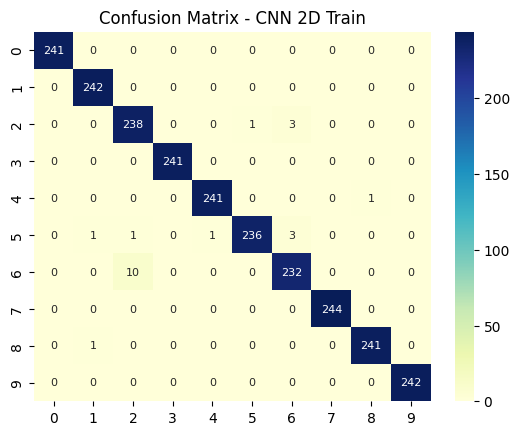

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


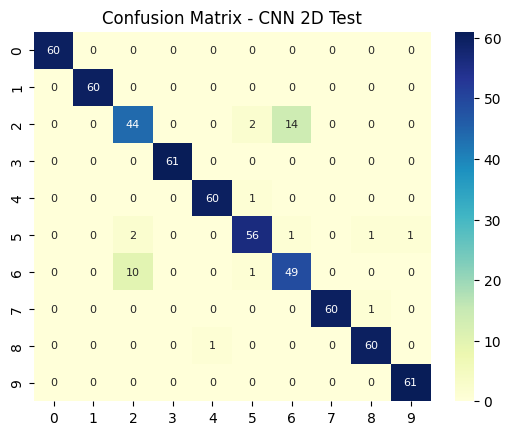

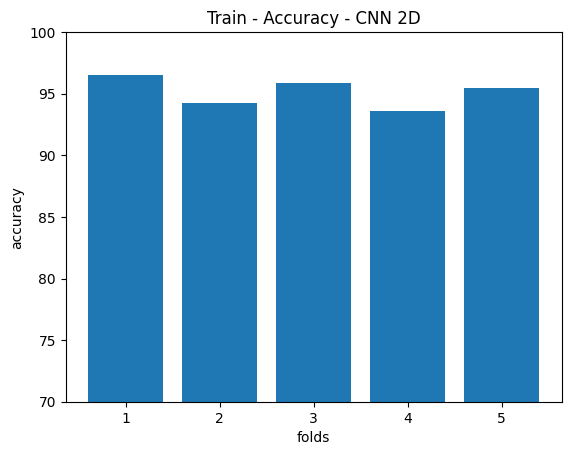

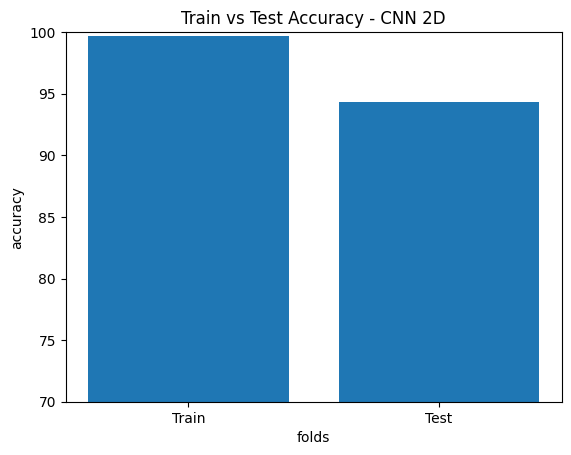

In [37]:
"""
# -----------------------------------------------------------------------------
# Multiclass Classification CNN Model Evaluation
# -----------------------------------------------------------------------------
"""

# Classification_2D.model.summary()

CNN_2D_train_accuracy = np.average(accuracy_train)*100
print('CNN 2D train accuracy =', CNN_2D_train_accuracy)
# print(accuracy_train)

CNN_2D_val_accuracy = np.average(accuracy_val)*100
print('CNN 2D validation accuracy =', CNN_2D_val_accuracy)
# print(accuracy_val)

CNN_2D_test_accuracy = np.average(accuracy_test)*100
print('CNN 2D test accuracy =', CNN_2D_test_accuracy)
# print(accuracy_test)

# Evaluate the accuracy of the model on the test set
# CNN_2D_test_loss, CNN_2D_test_accuracy = Classification_2D.model.evaluate(X_2D_test, y_2D_test)
# CNN_2D_test_accuracy*=100
# print('CNN 2D test accuracy =', CNN_2D_test_accuracy)


def ConfusionMatrix(Model, X, y):
  y_pred = np.argmax(Model.predict(X), axis=1)
  ConfusionMat = confusion_matrix(np.argmax(y, axis=1), y_pred)
  return ConfusionMat

# Plot results - CNN 2D
plt.figure(5)
plt.title('Confusion Matrix - CNN 2D Train') 
sns.heatmap(ConfusionMatrix(CNN_2D_best_model, X_2D_train, y_2D_train) , annot=True, fmt='d',annot_kws={"fontsize":8},cmap="YlGnBu")
plt.show()

plt.figure(6)
plt.title('Confusion Matrix - CNN 2D Test') 
sns.heatmap(ConfusionMatrix(CNN_2D_best_model, X_2D_test, y_2D_test) , annot=True, fmt='d',annot_kws={"fontsize":8},cmap="YlGnBu")
plt.show()

plt.figure(7)
plt.title('Train - Accuracy - CNN 2D')
plt.bar(np.arange(1,kSplits+1),[i*100 for i in accuracy_val])
plt.ylabel('accuracy')
plt.xlabel('folds')
plt.ylim([70,100])
plt.show()

plt.figure(8)
plt.title('Train vs Test Accuracy - CNN 2D')
plt.bar([1,2],[CNN_2D_train_accuracy,CNN_2D_test_accuracy])
plt.ylabel('accuracy')
plt.xlabel('folds')
plt.xticks([1,2],['Train', 'Test'])
plt.ylim([70,100])
plt.show()

In [96]:
from tensorflow.keras.models import load_model

# for i in range(1, 6):
#     filepath = f"CNN2D_results/V4_2_NOL_exp1/best_model_{i}.h5"
#     print(f"\nModel summary for fold {i}:")
#     model = load_model(filepath)
#     model.summary()
#     for i, layer in enumerate(model.layers):
#         print(f"{i}: {layer.name} — {layer.output_shape}")


filepath = f"CNN2D_results/V4_2_NOL_exp1/best_model_1.h5"
print(f"\nModel summary for fold 1:")
model = load_model(filepath)
model.summary()
for i, layer in enumerate(model.layers):
    print(f"{i}: {layer.name}")
    
model.predict(X_2D_test)
layer_name = 'conv2d_20'  
intermediate_model = tf.keras.Model(inputs=model.input, outputs=model.get_layer(layer_name).output)






Model summary for fold 1:


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_20 (Conv2D)              │ (None, 40, 40, 16)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_20 (MaxPooling2D) │ (None, 20, 20, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (None, 20, 20, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_21 (MaxPooling2D) │ (None, 10, 10, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_22 (Conv2D)              │ (None, 10, 10, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_22 (MaxPooling2D) │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 5, 5, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_23 (MaxPooling2D) │ (None, 3, 3, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 100)            │       115,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 50)             │         5,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 10)             │           510 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ softmax_5 (Softmax)             │ (None, 10)             │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 218,014 (851.62 KB)

 Trainable params: 218,012 (851.61 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

0: conv2d_20
1: max_pooling2d_20
2: conv2d_21
3: max_pooling2d_21
4: conv2d_22
5: max_pooling2d_22
6: conv2d_23
7: max_pooling2d_23
8: flatten_5
9: dense_15
10: dense_16
11: dense_17
12: softmax_5
 6/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

2025-06-05 14:23:37.746124: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-06-05 14:23:37.746996: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


AttributeError: The layer sequential_5 has never been called and thus has no defined input.